In [2]:
import pandas as pd
import csv
import random
from statsmodels.stats.proportion import proportions_ztest

In [27]:
# Script para remover dados irelevantes e que atrapalham o desempenho da análise

# df = pd.read_csv('viagem.csv', delimiter=';')

# df_novo = df.copy()
# df_novo['trajeto'] = ''

# def map_activity (value):
#     if pd.notna(value):
#         return 't'
#     else:
#         return 'f'

# df_novo['activityrecognitiontrip'] = df_novo['activityrecognitiontrip'].apply(lambda x: map_activity(x))

# df_novo.to_csv('viagem_sem_trajeto_sem_activity.csv', index=False, sep=';')

In [37]:
arquivo_feedback_viagem_modo_aviao = 'feedback_viagem_modo_aviao.csv'
arquivo_feedback_viagem_parada_10_minutos = 'feedback_viagem_parada_10_minutos.csv'
arquivo_feedback_viagem_perdida = 'feedback_viagem_perdida.csv'
arquivo_feedback_viagem = 'feedback_viagem.csv'
arquivo_viagem_sem_trajeto_sem_activity = 'viagem_sem_trajeto_sem_activity.csv'

feedback_viagem_modo_aviao = pd.read_csv(arquivo_feedback_viagem_modo_aviao, delimiter=';')
feedback_viagem_parada_10_minutos = pd.read_csv(arquivo_feedback_viagem_parada_10_minutos, delimiter=';', quoting=csv.QUOTE_NONE)
feedback_viagem_perdida = pd.read_csv(arquivo_feedback_viagem_perdida, delimiter=';')
feedback_viagem = pd.read_csv(arquivo_feedback_viagem, delimiter=';', quoting=csv.QUOTE_NONE)
viagem = pd.read_csv(arquivo_viagem_sem_trajeto_sem_activity, delimiter=';')


# Comparação da resposta do servidor com o **Modo Avião ativado** e **Pequenas Pausas no trajeto**

Os dados foram coletados em dois cenários: celular com modo avião ativo e pausas no trajeto. Primeiramente, queremos avaliar se a funcionalidade de modo avião interferiu na precisão da resposta do servidor. Depois analisamos o quanto a pausa de 10 minutos no percurso afetou a desaprovação da viagem.

Para essa análise, desconsideramos erros do usuário, nomeadamente 'ORIGEM_IGUAL_DESTINO' e 'LIMITES_VIAGEM_EXCEDIDO', e procedimento do servidor, como 'VIAGEM_VALIDACAO' e 'PILOTO_NAO_INICIADO'. Portanto, consideramos sucesso as viagens com coluna 'motivooriginal' com valor 'APROVADO' e problemas causados pelos cenários que a aplicação foi exposta as viagens com 'motivooriginal' igual a 'NAO_BICICLETA', 'POUCOS_PONTOS', 'TEMPO_SEM_AMOSTRA'.

['ORIGEM_IGUAL_DESTINO' 'NAO_BICICLETA' 'POUCOS_PONTOS' 'APROVADO'
 'VIAGEM_VALIDACAO' 'LIMITE_VIAGENS_EXCEDIDO' 'PILOTO_NAO_INICIADO'
 'TEMPO_SEM_AMOSTRA']


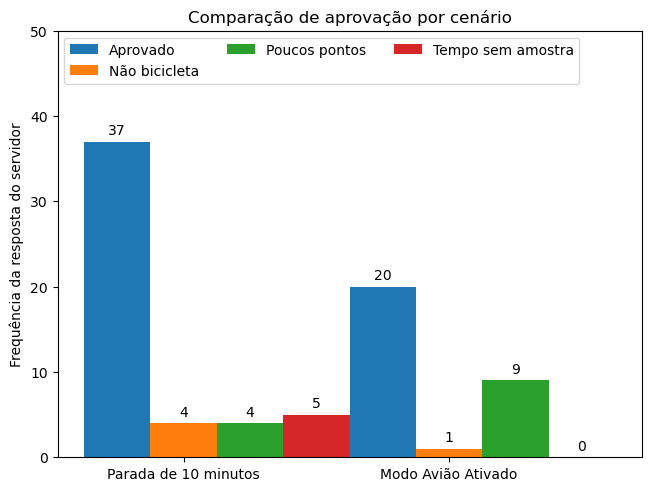

In [13]:
import matplotlib.pyplot as plt
import numpy as np
# aprovados = viagem['motivostatus'].value_counts().get('APROVADO', 0)

# Data Frames quando o modo avião está ativo
aprovados_modo_aviao = feedback_viagem_modo_aviao['motivooriginal'].value_counts().get('APROVADO', 0)
modo_aviao_nao_bicicleta = feedback_viagem_modo_aviao['motivooriginal'].value_counts().get('NAO_BICICLETA', 0)
modo_aviao_poucos_pontos = feedback_viagem_modo_aviao['motivooriginal'].value_counts().get('POUCOS_PONTOS', 0)
modo_aviao_tempo_sem_amostra = feedback_viagem_modo_aviao['motivooriginal'].value_counts().get('TEMPO_SEM_AMOSTRA', 0)

# Data Frames quando houve uma pausa de 10 minutos
aprovados_parada_10_minutos = feedback_viagem_parada_10_minutos['motivooriginal'].value_counts().get('APROVADO', 0)
parada_10_minutos_nao_bicicleta = feedback_viagem_parada_10_minutos['motivooriginal'].value_counts().get('NAO_BICICLETA', 0)
parada_10_minutos_poucos_pontos = feedback_viagem_parada_10_minutos['motivooriginal'].value_counts().get('POUCOS_PONTOS', 0)
parada_10_minutos_tempo_sem_amostra = feedback_viagem_parada_10_minutos['motivooriginal'].value_counts().get('TEMPO_SEM_AMOSTRA', 0)

print(viagem['motivostatus'].unique())

cenarios = {"Modo Avião Ativado", "Parada de 10 minutos"}
respostaServidor = {
    'Aprovado': (aprovados_modo_aviao, aprovados_parada_10_minutos),
    'Não bicicleta': (modo_aviao_nao_bicicleta, parada_10_minutos_nao_bicicleta),
    'Poucos pontos': (modo_aviao_poucos_pontos, parada_10_minutos_poucos_pontos),
    'Tempo sem amostra': (modo_aviao_tempo_sem_amostra, parada_10_minutos_tempo_sem_amostra)
}

x = np.arange(len(cenarios))
width = 0.25
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for atribute, measurement in respostaServidor.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=atribute)
    ax.bar_label(rects, padding=3)
    multiplier +=1

ax.set_ylabel('Frequência da resposta do servidor')
ax.set_title('Comparação de aprovação por cenário')
ax.set_xticks(x + width, cenarios)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 50)

plt.show()

## Teste de Hipótese

Queremos comparar a influência dos cenários na precisão de resposta do servidor. Para isso, utilizaremos o conceito estatístico de teste de hipótese.

Como temos um conjunto relativamente grande de dados e queremos medir as "proporções" de aprovações, julgamos conviniênte utilizar o teste de Proporções

In [35]:
seed = 42

random.seed(seed)

volume_amostra_modo_aviao = aprovados_modo_aviao + modo_aviao_nao_bicicleta + modo_aviao_poucos_pontos + modo_aviao_tempo_sem_amostra
volume_amostra_parada_10_minutos = aprovados_parada_10_minutos + parada_10_minutos_nao_bicicleta + parada_10_minutos_poucos_pontos + parada_10_minutos_tempo_sem_amostra

index_aleatorio_sem_modo_aviao = [random.randint(0, viagem['idviagem'].size) for _ in range(volume_amostra_modo_aviao)]
index_aleatorio_sem_parada_10_minutos = [random.randint(0, viagem['idviagem'].size) for _ in range(volume_amostra_parada_10_minutos)]

aprovados_sem_modo_aviao = sum(viagem.loc[index_aleatorio_sem_modo_aviao, 'motivostatus'] == 'APROVADO')
aprovados_sem_parada_10_minutos = sum(viagem.loc[index_aleatorio_sem_parada_10_minutos, 'motivostatus'] == 'APROVADO')

### Modo Avião

**Hipotese Nula** (H_0): O modo avião não afeta o status de aprovação

**Hipotese Alternativa** (H_1): O modo avião afeta o status de aprovação

In [25]:
stat_modo_aviao, p_valor_modo_aviao = proportions_ztest([aprovados_modo_aviao, aprovados_sem_modo_aviao], [volume_amostra_modo_aviao, volume_amostra_modo_aviao])

print(f"Estatística de teste: {stat_modo_aviao}")
print(f"p-valor: {p_valor_modo_aviao}")

print('\n')

alpha = 0.05
if p_valor_modo_aviao < alpha:
    print("Rejeitar H_0: Existem evidências estatísticas de que o modo avião afeta o status de aprovação.")
else:
    print("Aceitar H_0: Não existem evidências estatísticas de que o modo avião afeta o status de aprovação.")

Estatística de teste: 1.6888013236829966
p-valor: 0.09125751009436339


Aceitar H_0: Não existem evidências estatísticas de que o modo avião afeta o status de aprovação.


### Parada de 10 minutos

**Hipostese Nula** (H_0): A parada não afeta o status de aprovação

**Hipostese Alternativa** (H_1): A parada afeta o status de aprovação

In [36]:
stat_parada_10_minutos, p_valor_parada_10_minutos = proportions_ztest([aprovados_parada_10_minutos, aprovados_sem_parada_10_minutos], [volume_amostra_parada_10_minutos, volume_amostra_parada_10_minutos])

print(f"Estatística de teste: {stat_parada_10_minutos}")
print(f"p-valor: {p_valor_parada_10_minutos}")

print('\n')

alpha = 0.05
if p_valor_parada_10_minutos < alpha:
    print("Rejeitar H_0: Existem evidências estatísticas de que a parada de 10 minutos afetam o status de aprovação")
else:
    print("Aceitar H_0: Não existem evidências estatísticas de que a parada de 10 minutos afetam o status de aprovação")

Estatística de teste: 1.563150317156718
p-valor: 0.11801724285265297


Aceitar H_0: Não existem evidências estatísticas de que a parada de 10 minutos afetam o status de aprovação


## Comparação da eficácia do Activity Recognition

Iremos separar o conjunto de dados viagem_sem_trajeto_sem_activity.csv em dois grupos, cujo activityrecognitiontrip foi usado e outro no qual a aprovação contou unicamente com os dados do trajeto.

In [59]:
total_com_activity = viagem['activityrecognitiontrip'].eq('t').sum()
total_sem_activity = viagem['activityrecognitiontrip'].eq('f').sum()

aprovados_com_activity = viagem[(viagem['motivostatus'] == 'APROVADO') & (viagem['activityrecognitiontrip'] == 't')].shape[0]
aprovados_sem_activity = viagem[(viagem['motivostatus'] == 'APROVADO') & (viagem['activityrecognitiontrip'] == 'f')].shape[0]

percentual_aprovados_com_activity = (aprovados_com_activity / total_com_activity) * 100
percentual_aprovados_sem_activity = (aprovados_sem_activity / total_sem_activity) * 100

print(f"Porcentual de aprovação com activity: {percentual_aprovados_com_activity}")
print(f"Porcentual de aprovação sem activity: {percentual_aprovados_sem_activity}")


Porcentual de aprovação com activity: 28.941176470588236
Porcentual de aprovação sem activity: 60.0
